In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy import io

In [2]:
for data_name in ["mnist", "spam"]:
    data = io.loadmat("data/%s_data.mat" % data_name)
    print("\nloaded %s data!" % data_name)
    fields = "test_data", "training_data", "training_labels"
    for field in fields:
        print(field, data[field].shape)


loaded mnist data!
test_data (10000, 784)
training_data (60000, 784)
training_labels (60000, 1)

loaded spam data!
test_data (5857, 32)
training_data (5172, 32)
training_labels (5172, 1)


In [3]:
mnist_data = io.loadmat("data/mnist_data.mat")
shuffled_data, shuffled_labels = mnist_data['training_data'], mnist_data['training_labels']
val_mnist_data = shuffled_data[:10000]
val_mnist_labels = shuffled_labels[:10000]
mnist_data = shuffled_data[10000:]
mnist_labels = shuffled_labels[10000:]

In [4]:
spam_data = io.loadmat("data/spam_data.mat")
shuffled_data_spam, shuffled_labels_spam = spam_data['training_data'], spam_data['training_labels']
length = round(shuffled_data.shape[0]*.2)
val_spam_data = shuffled_data[:length]
val_spam_labels = shuffled_labels[:length]
shuf_spam_data = shuffled_data[length:]
shuf_spam_labels = shuffled_labels[length:]

In [5]:
norms = np.linalg.norm(mnist_data,axis=1)
normalized_data = []
for i in range(len(norms)):
    normalized_data += [mnist_data[i]/norms[i]]

In [6]:
groups = {}
for i in range(0,10):
    groups[str(i)] = []
for i in range(len(mnist_data)):
    groups[str(mnist_labels[i][0])] += [normalized_data[i]]

In [7]:
priors = {}
total = 0
for i in range(0,10):
    total += len(groups[str(i)])
for i in range(0,10):
    priors[str(i)] = len(groups[str(i)])/total

In [8]:
means = {}
for i in range(0,10):
    means[str(i)] = []
for key, value in groups.items():
    means[key] = np.mean(value,axis=0)

In [9]:
cov = {}
for i in range(0,10):
    cov[str(i)] = []
for key, value in groups.items():
    cov[key] = np.cov(np.asmatrix(value).T)

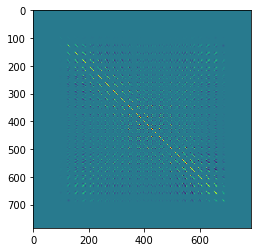

In [10]:
plt.imshow(cov['0'])

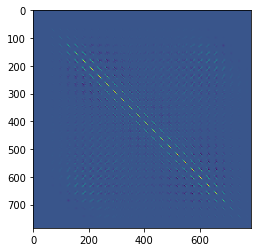

In [11]:
covlist = []
for key, value in cov.items():
    covlist+=[np.matrix.flatten(cov[key])]

mean_cov = np.mean(covlist,axis=0)
average_cov = mean_cov.reshape(784,784)
plt.imshow(average_cov)

In [12]:
average_cov_pseudo = np.linalg.pinv(average_cov)
mu_sig_invs = {}
for i in range(0,10):
    mu_sig_invs[str(i)] = []
for i in range(0,10):
    mu = means[str(i)]
    mu_sig_invs[str(i)] = np.dot(mu.T,average_cov_pseudo)


In [13]:
def Loss_of_LDA(train, labels, val_data, val_labels):
    norms = np.linalg.norm(train,axis=1)
    normalized_data = []
    for i in range(len(norms)):
        normalized_data += [train[i]/norms[i]]
    
    
    groups = {}
    for i in range(0,10):
        groups[str(i)] = []
    for i in range(len(train)):
        groups[str(labels[i][0])] += [normalized_data[i]]
    
    
    priors = {}
    total = 0
    for i in range(0,10):
        total += len(groups[str(i)])
    for i in range(0,10):
        priors[str(i)] = len(groups[str(i)])/total

    
    means = {}
    for i in range(0,10):
        means[str(i)] = []
    for key, value in groups.items():
        means[key] = np.mean(value,axis=0)
    
    cov = {}
    for i in range(0,10):
        cov[str(i)] = []
    for key, value in groups.items():
        cov[key] = np.cov(np.asmatrix(value).T)
    
    covlist = []
    for key, value in cov.items():
        covlist+=[np.matrix.flatten(cov[key])]

    mean_cov = np.mean(covlist,axis=0)
    average_cov = mean_cov.reshape(784,784)
#     plt.imshow(average_cov)
    
    average_cov_pseudo = np.linalg.pinv(average_cov)
    mu_sig_invs = {}
    for i in range(0,10):
        mu_sig_invs[str(i)] = []
    for i in range(0,10):
        mu = means[str(i)]
        mu_sig_invs[str(i)] = np.dot(mu.T,average_cov_pseudo)
    
    
    val_data_t = val_data.T
    val_label_t = val_labels.T
    
    class_results = []
    for i in range(0,10):
        result = mu_sig_invs[str(i)].dot(val_data_t)-.5*(mu_sig_invs[str(i)].dot(means[str(i)]))+np.log(priors[str(i)])
        class_results += [result]
    predictions = np.argmax(class_results,axis=0)
    final = []
    for pred in predictions:
        final.append([pred])
    result = np.array(final)
    
    loss = np.equal(result,val_labels)
    loss = loss.flatten()
    total_loss = np.sum(np.logical_not(loss))
    return total_loss/len(loss)

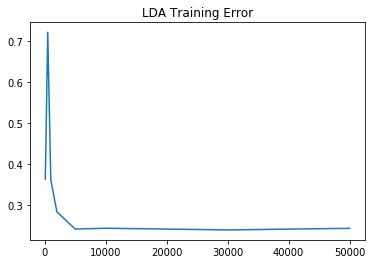

In [14]:
x = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
error_rates = []
for i in x:
    error_rate = Loss_of_LDA(mnist_data[:i],mnist_labels[:i],mnist_data,mnist_labels)
    error_rates += [error_rate]
plt.plot(x,error_rates)
plt.title("LDA Training Error")
plt.show()

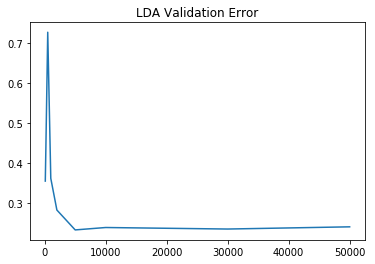

In [16]:
x = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
error_rates = []
for i in x:
    error_rate = Loss_of_LDA(mnist_data[:i],mnist_labels[:i],val_mnist_data,val_mnist_labels)
    error_rates += [error_rate]
plt.plot(x,error_rates)
plt.title("LDA Validation Error")
plt.show()

In [17]:
def Loss_of_QDA(train, labels, val_data, val_labels):
    norms = np.linalg.norm(train,axis=1)
    normalized_data = []
    for i in range(len(norms)):
        normalized_data += [train[i]/norms[i]]
    
    
    groups = {}
    for i in range(0,10):
        groups[str(i)] = []
    for i in range(len(train)):
        groups[str(labels[i][0])] += [normalized_data[i]]
    
    
    priors = {}
    total = 0
    for i in range(0,10):
        total += len(groups[str(i)])
    for i in range(0,10):
        priors[str(i)] = len(groups[str(i)])/total

    
    means = {}
    for i in range(0,10):
        means[str(i)] = []
    for key, value in groups.items():
        means[key] = np.mean(value,axis=0)
    
    cov = {}
    for i in range(0,10):
        cov[str(i)] = []
    for key, value in groups.items():
        cov[key] = np.cov(np.asmatrix(value).T)
    

    cov_pseudos = {}
    mu_sig_invs = {}
    for i in range(0,10):
        mu_sig_invs[str(i)] = []
        cov_pseudos[str(i)] = []
    for i in range(0,10):
        mu = means[str(i)]
        cov_pseudos[str(i)] = np.linalg.pinv(cov[str(i)]).astype(float)
    
    
    val_data_t = val_data.T
    val_label_t = val_labels.T
    
    class_results = []
    for i in range(0,10):
        mu_matrix = means[str(i)][None,:].repeat(len(val_data),axis=0).astype(float).T

        result1 = (np.subtract(val_data_t,mu_matrix)).astype(float).T

        result2 = result1.dot(cov_pseudos[str(i)]).astype(float)
        result3 = -.5*result2.dot((np.subtract(val_data_t,mu_matrix))).astype(float)
        sign,det = np.linalg.slogdet(cov[str(i)])
        
        result4 = result3 - .5 * sign * det
        result =  result4 + np.log(priors[str(i)])
        result = result.diagonal()
        
#         result = result1*result2*result3-result4+result5
        class_results += [result]
    
    predictions = np.argmax(class_results,axis=0)

    final = []
    for pred in predictions:
        final.append([pred])
    result = np.array(final)
    print(result)
    print("\n\n")
    print(val_labels)
    loss = np.equal(result,val_labels)

    loss = loss.flatten()
    total_loss = np.sum(np.logical_not(loss))
    
    return total_loss/len(loss)

In [18]:
x = [100, 200, 500, 1000] #2000, 5000, 10000, 30000, 50000]
error_rates = []
for i in x:
    error_rate = Loss_of_QDA(mnist_data[:i],mnist_labels[:i],val_mnist_data,val_mnist_labels)
    error_rates += [error_rate]
    print(error_rate)
    
plt.plot(x,error_rates)
plt.title("QDA Training Error")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [19]:
mnist_data = io.loadmat("data/mnist_data.mat")
shuffled_data, shuffled_labels = mnist_data['training_data'], mnist_data['training_labels']
test_d = mnist_data['test_data']
mnist_data = shuffled_data
mnist_labels = shuffled_labels


def final_LDA(train, labels,val_data):
    norms = np.linalg.norm(train,axis=1)
    normalized_data = []
    for i in range(len(norms)):
        normalized_data += [train[i]/norms[i]]
    
    
    groups = {}
    for i in range(0,10):
        groups[str(i)] = []
    for i in range(len(train)):
        groups[str(labels[i][0])] += [normalized_data[i]]
    
    
    priors = {}
    total = 0
    for i in range(0,10):
        total += len(groups[str(i)])
    for i in range(0,10):
        priors[str(i)] = len(groups[str(i)])/total

    
    means = {}
    for i in range(0,10):
        means[str(i)] = []
    for key, value in groups.items():
        means[key] = np.mean(value,axis=0)
    
    cov = {}
    for i in range(0,10):
        cov[str(i)] = []
    for key, value in groups.items():
        cov[key] = np.cov(np.asmatrix(value).T)
    
    covlist = []
    for key, value in cov.items():
        covlist+=[np.matrix.flatten(cov[key])]

    mean_cov = np.mean(covlist,axis=0)
    average_cov = mean_cov.reshape(784,784)
#     plt.imshow(average_cov)
    
    average_cov_pseudo = np.linalg.pinv(average_cov)
    mu_sig_invs = {}
    for i in range(0,10):
        mu_sig_invs[str(i)] = []
    for i in range(0,10):
        mu = means[str(i)]
        mu_sig_invs[str(i)] = np.dot(mu.T,average_cov_pseudo)
    
    
    val_data_t = val_data.T
    
    class_results = []
    for i in range(0,10):
        result = mu_sig_invs[str(i)].dot(val_data_t)-.5*(mu_sig_invs[str(i)].dot(means[str(i)]))+np.log(priors[str(i)])
        class_results += [result]
    predictions = np.argmax(class_results,axis=0)
    final = []
    for pred in predictions:
        final.append(pred)
    result = np.array(final)
    
    return result
    

In [20]:
import pandas as pd
def results_to_csv(y_test,name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('%ssubmission.csv' % name, index_label='Id')

mnist_pred = final_LDA(mnist_data,mnist_labels,test_d)
results_to_csv(mnist_pred,"mnist")

In [21]:
spam_data = io.loadmat("data/spam_data.mat")
shuffled_data_spam, shuffled_labels_spam = spam_data['training_data'], spam_data['training_labels']
test_spam = spam_data['test_data']
shuf_spam_data = shuffled_data_spam
shuf_spam_labels = shuffled_labels_spam

def final_LDA(train, labels, val_data):
    norms = np.linalg.norm(train,axis=1)
    normalized_data = []
    for i in range(len(norms)):
        normalized_data += [train[i]/norms[i]]
    
    
    classes = {}
    for i in range(0,2):
        classes[str(i)] = []
    for i in range(len(train)):
        classes[str(labels[i][0])] += [normalized_data[i]]
    
    
    priors = {}
    total = 0
    for i in range(0,2):
        total += len(classes[str(i)])
    for i in range(0,2):
        priors[str(i)] = len(classes[str(i)])/total

    
    means = {}
    for i in range(0,2):
        means[str(i)] = []
    for key, value in classes.items():
        means[key] = np.mean(value,axis=0)
    
    cov = {}
    for i in range(0,2):
        cov[str(i)] = []
    for key, value in classes.items():
        cov[key] = np.cov(np.asmatrix(value).T)
    
    covlist = []
    for key, value in cov.items():
        covlist+=[np.matrix.flatten(cov[key])]

    mean_cov = np.mean(covlist,axis=0)
    average_cov = mean_cov.reshape(32,32)
    
    average_cov_pseudo = np.linalg.inv(average_cov)
    mu_sig_invs = {}
    for i in range(0,2):
        mu_sig_invs[str(i)] = []
    for i in range(0,2):
        mu = means[str(i)]
        mu_sig_invs[str(i)] = np.dot(mu.T,average_cov_pseudo)
    
    
    val_data_t = val_data.T
    
    class_results = []
    for i in range(0,2):
        result = mu_sig_invs[str(i)].dot(val_data_t)-.5*(mu_sig_invs[str(i)].dot(means[str(i)]))+np.log(priors[str(i)])
        class_results += [result]
        
    predictions = np.argmax(class_results,axis=0)
    final = []
    for pred in predictions:
        final.append(pred)
    result = np.array(final)
    
    return result


In [22]:
spam_pred = final_LDA(shuf_spam_data,shuf_spam_labels,test_spam)
results_to_csv(spam_pred,"spam")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [23]:
def Loss_of_LDA(train, labels, val_data, val_labels):
    norms = np.linalg.norm(train,axis=1)
    normalized_data = []
    for i in range(len(norms)):
        normalized_data += [train[i]/norms[i]]
    
    
    groups = {}
    for i in range(0,10):
        groups[str(i)] = []
    for i in range(len(train)):
        groups[str(labels[i][0])] += [normalized_data[i]]
    
    
    priors = {}
    total = 0
    for i in range(0,10):
        total += len(groups[str(i)])
    for i in range(0,10):
        priors[str(i)] = len(groups[str(i)])/total

    
    means = {}
    for i in range(0,10):
        means[str(i)] = []
    for key, value in groups.items():
        means[key] = np.mean(value,axis=0)
    
    cov = {}
    for i in range(0,10):
        cov[str(i)] = []
    for key, value in groups.items():
        cov[key] = np.cov(np.asmatrix(value).T)
    
    covlist = []
    for key, value in cov.items():
        covlist+=[np.matrix.flatten(cov[key])]

    mean_cov = np.mean(covlist,axis=0)
    average_cov = mean_cov.reshape(784,784)
#     plt.imshow(average_cov)
    
    average_cov_pseudo = np.linalg.pinv(average_cov)
    mu_sig_invs = {}
    for i in range(0,10):
        mu_sig_invs[str(i)] = []
    for i in range(0,10):
        mu = means[str(i)]
        mu_sig_invs[str(i)] = np.dot(mu.T,average_cov_pseudo)
    
    
    val_data_t = val_data.T
    val_label_t = val_labels.T
    
    class_results = []
    for i in range(0,10):
        result = mu_sig_invs[str(i)].dot(val_data_t)-.5*(mu_sig_invs[str(i)].dot(means[str(i)]))+np.log(priors[str(i)])
        class_results += [result]
    predictions = np.argmax(class_results,axis=0)
    final = []
    for pred in predictions:
        final.append([pred])
    result = np.array(final)
    
    loss = np.equal(result,val_labels)
    loss = loss.flatten()
    errors = []
    for i in range(0,10):
        mask = val_labels.copy()
        mask = np.array(mask.flatten())
        mask[mask != i] = 0
        mask[mask == i] = 1
        class_total = np.sum(mask)
        correct = np.array(mask).dot(np.array(loss))
        accuracy = correct/class_total
        error = 1-accuracy
        errors += [error]
    return errors

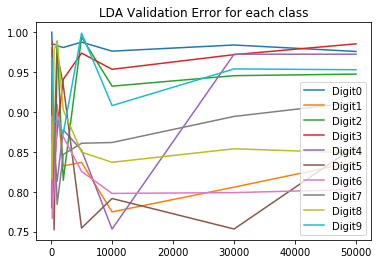

In [24]:
x = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
train_effect = []
for i in range(len(x)):
    train_effect += [Loss_of_LDA(mnist_data[:x[i]],mnist_labels[:x[i]],val_mnist_data,val_mnist_labels)]

train_effect = np.asmatrix(train_effect)
for i in range(len(train_effect)+1):
    plt.plot(x,train_effect[:,i],label = 'Digit' + str(i))
plt.title("LDA Validation Error for each class")
plt.legend()
plt.show()